# 自己紹介
竹田航太

所属: 京都大学 大学院理学研究科 数学教室 坂上研究室

学年: 1年

専攻: 応用数学

興味: 流体，UQ(Uncertainty Quantification)， データ同化，機械学習，気象予報

その他: 京都でwebエンジニアの長期インターンやってます． 趣味でランニングはじめました．

# RCCS DAオンラインスクール課題

課題

1. Lorenz-96を4次のRunge-Kutta法を用いて実装する。パラメータ値Fをいろいろ変え、F=8の時にカオスとなることを確認する。
余裕があれば、他の時間積分スキームも実装してみる。
2. パラメータ値F=8とする。誤差の平均発達率について調べ、0.2時間ステップを1日と定義することの妥当性を確認する。
3. 2年分積分し、最初の1年分をスピンアップとして捨てる。後半1年分を6時間毎に保存しておく。
4. Mersenne Twister等の性質の良い乱数生成プログラムを用いて分散1の正規分布乱数を生成する。
ヒストグラム等で意図した乱数が生成されていることを確認する。
その上で、３で保存した6時間毎の状態に足しこんで、別途保存する。これを観測データとする。
5. 6時間サイクルのデータ同化システムを構築する。Kalman Filter (KF)の式を直接解くものでよい。
ただし、KFの予報誤差共分散の部分に定数を入れられるように設計しておく。（定数を入れると、3次元変分法と同値である）。
6. 3次元変分法とKFとの比較実験を行う。この際、観測分布への依存性を調べる。また、パラメータ等への依存性も調査し、特徴を調べる。
7. EnKFを実装し、KFとの比較実験を行う。
Whitaker and Hamill (2002, MWR)によるEnSRFや、Bishop et al. (2001, MWR)によるETKF、Hunt et al. (Physica D, 2007)によるLETKF等。
8. 4次元変分法を実装し、比較する。4次元変分法には、アジョイントモデルを構築するほか、近似的に40x40行列の線形モデルを生成する方法もある。
もしアジョイントモデルを構築すれば、近似的な線形モデル行列との違いについて調べてみるのも面白いかもしれない。モデルの非線形性の調査になる。
線形モデルの場合一致することを確認する。
9. 発展的課題：完全モデルを仮定してきたが、モデル誤差を導入して同様の調査を行ってみる。

参考リンク
- 三好による京都大学での講義 (要パスワード)
- Lorenz and Emanuel, 1998: Optimal sites for supplementary weather observations:Simulation with a small model. J. Atmos. Sci., 55, 399−414.
- Whitaker and Hamill, 2002: Ensemble data assimilation without perturbedobservations. Mon. Wea. Rev., 130, 1913‒1924.
- Bishop et al., 2001: Adaptive sampling with the ensembletransform Kalman filter. Part I: Theoretical aspects. Mon. Wea. Rev., 129, 420‒436.
- Hunt et al., 2007: Efficient data assimilation forspatiotemporal chaos: A local ensemble transform Kalman filter, Physica D, 230, 112‒126.


## 準備

In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# モジュールの読み込み
import sys
sys.path.append('./')
from utils import make_lorenz96, rk4, euler

## 1. Lorenz-96を4次のRunge-Kutta法を用いて実装する。パラメータ値Fをいろいろ変え、F=8の時にカオスとなることを確認する。余裕があれば、他の時間積分スキームも実装してみる。

### 計算の準備
初期値: 
$ X_j = F $とし，摂動として$ X_{20} $に$ 1.001 $をかける．
$ X_{20} = F \cdot 1.001$

変数:
$J=40$

時間ステップ:
$N=360 \times 20$
(天下り的ではあるが１年分)

カオスの定義:
- 周期性がない(視認)
- 課題2でのリヤプノフ指数$\lambda$を計算しnot zero

以下の2種類のplotを行う．
- 摂動を加えた20番目の要素をplot
- 1,2,3番目の要素を3次元plot

TODO: Homvor diagram

In [22]:
def plot_lorenz96(result):
    result = np.array(result)

    # 摂動を加えた20番目の要素をplot
    fig1, ax1 = plt.subplots()
    ax1.plot(result[:, 19])
    ax1.set_xlabel('step')
    ax1.set_ylabel('$x_{20} $')
    plt.title('plot 20th component')

    # 1,2,3番目の要素を3次元plot
    fig2 = plt.figure()
    ax2 = fig2.gca(projection='3d')
    ax2.plot(result[:, 0], result[:, 1], result[:, 2])
    ax2.set_xlabel('$x_1$')
    ax2.set_ylabel('$x_2$')
    ax2.set_zlabel('$x_3$')
    plt.title('first three components of Lorenz96')
    
    # Hovmoller Diagram
    # 不完全 imshowを調査すべき
    x = np.arange(1,41)
    t = np.linspace(0, 2, 20)[::-1]
    X, T = np.meshgrid(x, t)
    Z = result[:2*20, :]
    
    fig3, ax3 = plt.subplots(figsize=(5,5))
    ax3.grid(False)
    plt.xticks(np.arange(1,40,5))
    plt.yticks([0, 1, 2])
    im = ax3.imshow(Z)
    plt.colorbar(im)
    
    plt.show()

In [20]:
# J: 変数の数
J = 40

# dt: 時間刻み
dt = 0.01

# N: 時間ステップ数
# 天下り的ではあるが1年分に相当
N = 360*20

# 任意のスキームでLorenz96を計算，plotする．
# 引数: scheme(t, x, dt, f) -> df
def simulate_lorenz96(scheme, plot=True):
    result = np.zeros((N,J))
    x = x0
    result[0] = x[:]

    for n in range(1,N):
        t = n*dt
        x = scheme(t, x, dt, lorenz)
        result[n] = x[:]
        
#  plot
    if plot:
        plot_lorenz96(result)

    return result

### 4次RungeKuttaでの計算結果

$F=8$

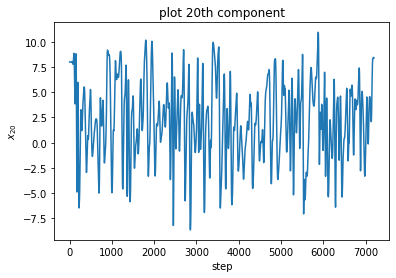

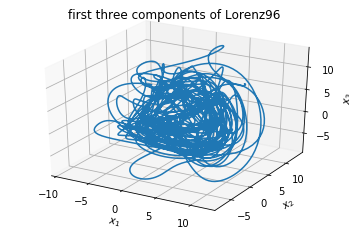

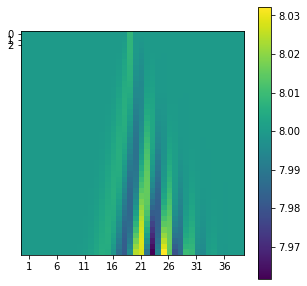

In [23]:
# 外力
F = 8

# 初期値の設定(摂動を加える)
x0 = F*np.ones(J)
x0[19] *= 1.001

lorenz = make_lorenz96(F)
x = simulate_lorenz96(rk4)

$F=4$

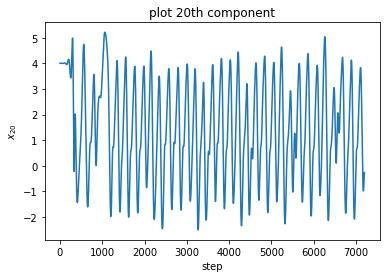

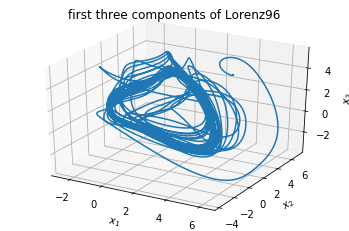

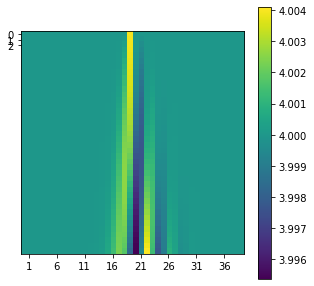

In [116]:
F = 4
x0 = F*np.ones(J)
x0[19] *= 1.001
lorenz = make_lorenz96(F)

_ = simulate_lorenz96(rk4)

$F=1$

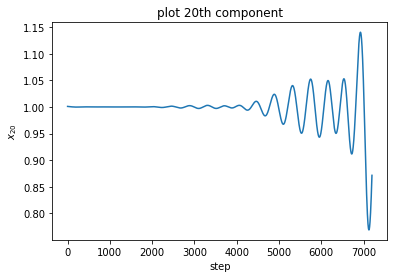

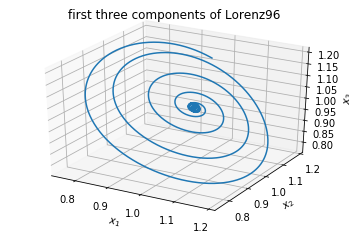

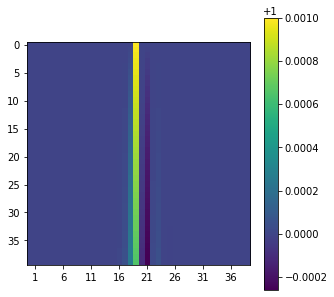

In [100]:
F = 1
x0 = F*np.ones(J)
x0[19] *= 1.001
lorenz = make_lorenz96(F)

_ = simulate_lorenz96(rk4)

## 2. パラメータ値F=8とする。誤差の平均発達率について調べ、0.2時間ステップを1日と定義することの妥当性を確認する。

### 方針
- rmseの平均発達率を調べる．
- アトラクター上の点をとり，ガウシアンノイズを加えた軌道との誤差の時間発展の平均を取る．

平均の取り方: 以下の2方向の平均をとる
- アトラクター平均
- 誤差の方向の平均をとる(atrと直交する方向にずらすとatrに近づく傾向にある)
<!-- - リヤプノフ指数を数値的に近似計算することによって誤差の平均発達率を評価する． -->

$F=8$

$dt=0.01$

$step=7 \cdot 20$

### 結果

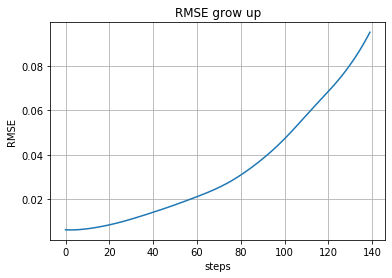

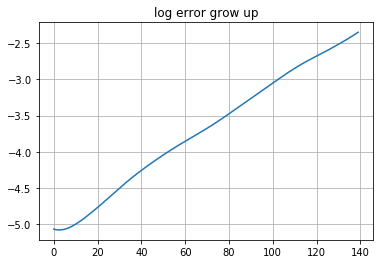

In [6]:
# 外力
F=8

lorenz = make_lorenz96(F)

# step数
# 天下り的ではあるが１週間分
N_step = 7*20

# atrからのサンプル数
N_atr_sample = 180//7

# ノイズについてのサンプル数
N_noise_sample = 5

# 時間刻み幅
dt = 0.01

# 摂動の大きさ
epsilon = 1e-3

error = np.zeros((N_atr_sample, N_step))
np.random.seed(1)

for m in range(N_atr_sample):
#     半分以降の軌道からサンプル
    z0 = x[180*20+7*20*m, :]
    z = np.zeros((N_step, J))
    z[0] = z0
    
    temp_error = np.zeros((N_noise_sample, N_step))
    
    for i in range(N_noise_sample):
        z_perturb = z[0] + epsilon*np.random.normal(size=z[0].shape)
        temp_error[i, 0] = np.linalg.norm(z[0] - z_perturb, ord=2)
    
        for n in range(1, N_step):
            t = n*dt
            if i == 0:
                z[n] = rk4(t, z[n-1], dt, lorenz)
            z_perturb = rk4(t, z_perturb, dt, lorenz)
            temp_error[i, n] = np.linalg.norm(z[n] - z_perturb, ord=2)
            
    error[m] = temp_error.mean(axis=0)[:]

error_mean = error.mean(axis=0)

# plot
fig, ax = plt.subplots()
ax.plot(error_mean)
ax.set_xlabel('steps')
ax.set_ylabel('RMSE')
plt.grid()
_ = plt.title('RMSE grow up')

# logを取ったものもplot
fig1, ax1 = plt.subplots()
ax1.plot(np.log(error_mean))
plt.grid()
_ = plt.title('log error grow up')

### 1から50step後の誤差の発達率を計算

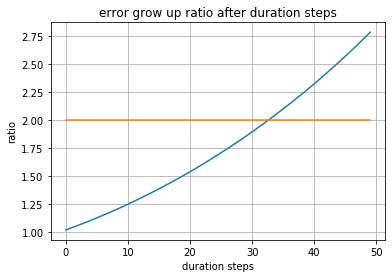

In [7]:
# duration = 40
error_mean_duration = np.array([
    np.array([error_mean[i+duration]/error_mean[i] for i in range(N_step-duration)]).mean()
    for duration in range(1,51)])

fig, ax = plt.subplots()
ax.plot(error_mean_duration)
ax.plot(2*np.ones(50))
ax.set_xlabel('duration steps')
ax.set_ylabel('ratio')
plt.grid()
_ = plt.title('error grow up ratio after duration steps')

#### 考察
- 約40回(37回くらい)ごとに誤差が2倍になっている．
- 論文によると気象学では2日で誤差が2倍になるとある．

よって$ dt = 0.01 $なので
$ 40 \times 0.01 = 2 day $から
$ 1 day = 0.2 $
と考える．


#### 誤差の収束
時間的に十分離れたattractor上の2点をとり誤差を調べる．

おおよそ5に近づく

In [218]:
N_atr_sample = 180
long_errors = np.zeros(N_atr_sample)
for m in range(N_atr_sample):
    z1 = x[20*m, :]
    z2 = x[180*20+20*m, :]
    long_errors[m] = np.linalg.norm(z1-z2, ord=2)/np.sqrt(40)
print(long_errors.mean())
_ = plt.plot(long_errors)

NameError: name 'x' is not defined

## 3. 2 年分積分し、最初の 1 年分をスピンアップとして捨てる。後半 1 年分を 6 時間毎に保存し ておく。

In [8]:
# J: 変数の数
J = 40

# 外力
F=8

# dt: 時間刻み
# 0.05で6h
dt = 0.01

# N: 時間ステップ数
# 2年分に相当
N = 360*2*20

result = simulate_lorenz96(rk4, plot=False)

# スピンアップを捨てる
x_one_year = result[360*20:]

# 6時間ごとを抽出
x_by_6h = x_one_year[::5]

np.save('data/true_atr.npy', x_by_6h)

npy形式で保存

In [67]:
load_true_atr = np.load('data/true_atr.npy')
load_true_atr.shape

(1440, 40)

## 4. Mersenne Twister 等の性質の良い乱数生成プログラムを用いて分散 1 の正規分布乱数を生成 し、3で保存した 6 時間毎の場に足しこんで、別途保存する。これを観測データとする。

### ノイズの挙動

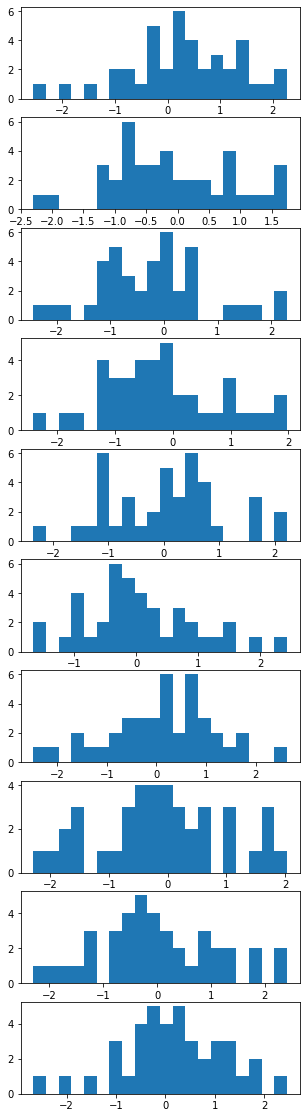

In [53]:
fig = plt.figure(figsize=(5,20))
for i in range(10):
    np.random.seed(i)
    ax = fig.add_subplot(10,1,i+1)
    ax.hist(np.random.normal(loc=0, scale=1, size=load_true_atr.shape[1]), bins=20)

標準正規分布$N(0,1)$に従うノイズを課題３で保存した真の値にのせて観測値として保存．

In [55]:
np.random.seed(1)
obs_atr = load_true_atr + np.random.normal(loc=0, scale=1, size=load_true_atr.shape)
np.save('data/obs_atr.npy', obs_atr)

In [65]:
load_obs_atr = np.load('data/obs_atr.npy')
load_obs_atr

array([[ 8.92505629,  7.56261642,  2.31744479, ...,  0.39952612,
         5.6461085 ,  5.69876668],
       [ 8.11922473,  6.06118038,  1.54373939, ...,  1.98084908,
         4.51648875,  7.31169176],
       [ 8.54930198,  4.52840234,  1.86700334, ...,  0.81248877,
         5.95145501,  8.54304758],
       ...,
       [ 2.34261244,  9.51683778,  7.14303893, ...,  4.44530601,
        -3.20437179,  2.98194449],
       [ 5.62706485, 10.37889661,  6.1879567 , ...,  5.67240533,
         1.06072394,  1.96077561],
       [ 8.04691746, 10.56153987, -0.54493199, ...,  7.44246992,
        -0.1275012 ,  2.04106529]])

真の値と観測データをプロット

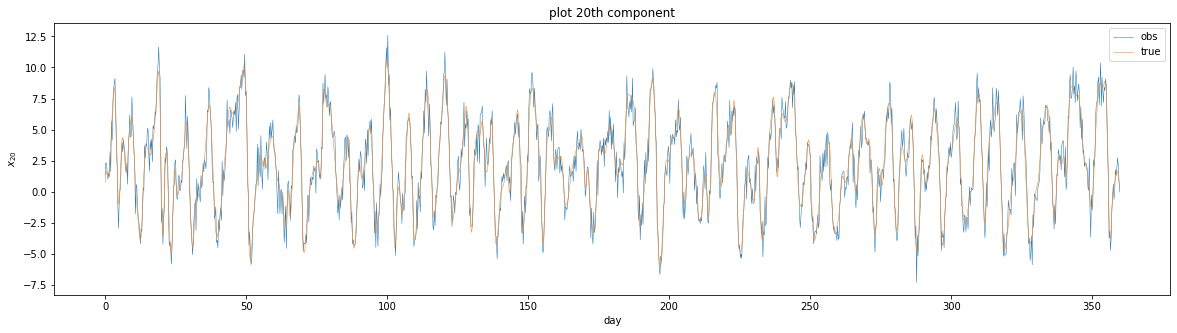

In [68]:
dates = [time/4 for time in range(1440)]
fig1, ax1 = plt.subplots(figsize=(20,5))
ax1.plot(dates, load_obs_atr[:, 19], '-', label='obs', lineWidth=0.5)
ax1.plot(dates, load_true_atr[:, 19],'-', label='true', lineWidth=0.5)
ax1.set_xlabel('day')
ax1.set_ylabel('$x_{20} $')
plt.title('plot 20th component')
_ = plt.legend()

## 5. 6時間サイクルのデータ同化システムを構築する。Kalman Filter (KF)の式を直接解くものでよい。
ただし、KFの予報誤差共分散の部分に定数を入れられるように設計しておく。（定数を入れると、3次元変分法と同値である）。


In [2]:
from kalman_filters import ExtendedKalmanFilter as ExKF

## 6. 3次元変分法とKFとの比較実験を行う。この際、観測分布への依存性を調べる。また、パラメータ等への依存性も調査し、特徴を調べる。

### 誤差の評価
- 各時刻で$ L^2$ノルム $ \frac{1}{\sqrt{40}}\| y_{obs} - x_{true}\| , \frac{1}{\sqrt{40}}\|x_a - x_{true}\| $をplot
- つまり各時刻で標準偏差を計算している．

In [163]:
# true: 真の値
# obs: 観測値
# kf_results: kfに推定値(複数可)
# 例: plot_error_KF (true, obs, [result1, result2])
def plot_error_KF(true, obs, kf_results, legends=['filtering error']):
    results = np.array(kf_results)
    T = len(true)

    # 誤差をplot
    obs_error = np.array([np.linalg.norm(obs[t] - true[t])/np.sqrt(J) for t in range(T)])

    # plot
    fig, ax = plt.subplots(figsize=(20,3))
    ax.plot(obs_error, label='obs error', lineWidth=0.5)
    for k in range(len(results)):
        filtering_error = np.array([np.linalg.norm(results[k, t] - true[t])/np.sqrt(J) for t in range(T)])
        ax.plot(filtering_error, label=legends[k].format(k), lineWidth=0.5)
    ax.set_xlabel('step')
    ax.set_ylabel('$ error $')
    plt.title('obs and filtering error')
    plt.legend()
    
    plt.show()

### 設定
- モデルの遷移関数$M$は非線形なのでforecast stepの予報誤差共分散行列を計算する際に接線形近似を行う必要がある．
  - サイクルのステップ幅を接線形近似が成り立つ範囲でとる必要がある．
- 最初は完全モデルを仮定($Q=0$)
- 観測は単位行列もしくはそのrankを落とした単位行列を使う．
- $R = I $で観測データを生成したのでこれを使う．のちに$ R = rI$として$r$を変化させる．
- 初期値:
    - $x_0 = y_0$
    - $P_0 = 25I$: 単位行列の25倍がスタンダード

In [183]:
# Lorenz96の設定
J = 40
F = 8
lorenz = make_lorenz96(F)

# 同化step
# 時間発展は0.01ごとに行う
dt = 0.05

# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, dt):
    for i in range(int(dt/0.01)):
        x = rk4(0, x, 0.01, lorenz)
    return x

# 単位行列
I = np.identity(J)

# 観測
H = I

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((J, J))

# 観測誤差共分散, 後で定数倍の変化をさせる.
R = I

# 観測値と真値
y = np.load('data/obs_atr.npy')[1:]
true = np.load('data/true_atr.npy')[1:]

# KFの初期値
x_0 = y[0]
P_0 = 25*I

### ExKF
完全モデルを仮定

In [77]:
exkf = ExKF(M, H, Q, R, y, x_0, P_0, dim_x=J, dt=dt)
exkf.forward_estimation(verbose=False)

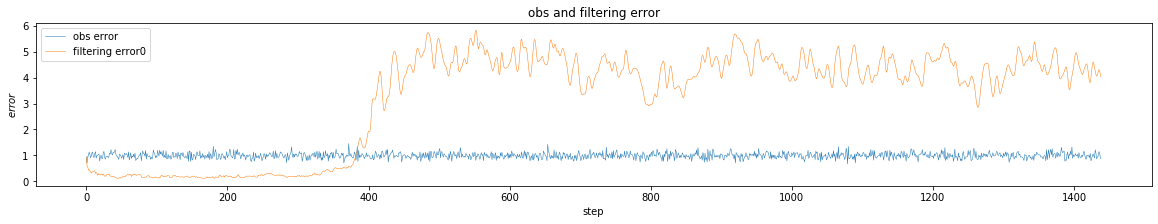

In [160]:
plot_error_KF(true, y, [exkf.x])

観察
- 最初は推定誤差が観測誤差より小さくなっているが，ある時刻を超えると観測誤差を超えて大きくなってしまっている．
  - 原因: 予報誤差共分散が時間経過とともに小さくなってしまって，モデルを信用しすぎてデータに含まれるノイズについていけていない．
  - 対策: 誤差共分散膨張により予報誤差共分散が小さくなりすぎるのを防ぐ．

### 3次元変分法
予報誤差共分散を更新しない．速い．

In [184]:
# 予報誤差共分散の初期値更新しないので小さくしておく
P_00 = I

var3d = ExKF(M, H, Q, R, y, x_0, P_00, dim_x=J, dt=dt, var3d=True)
var3d.forward_estimation(verbose=False)

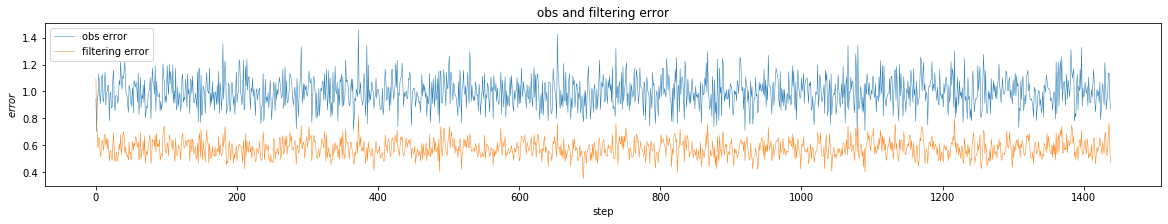

In [185]:
plot_error_KF(true, y, [var3d.x])

観察
- 観測データよりは良い推定を安定して行うことができている．

### ExKFと3次元変分法の比較

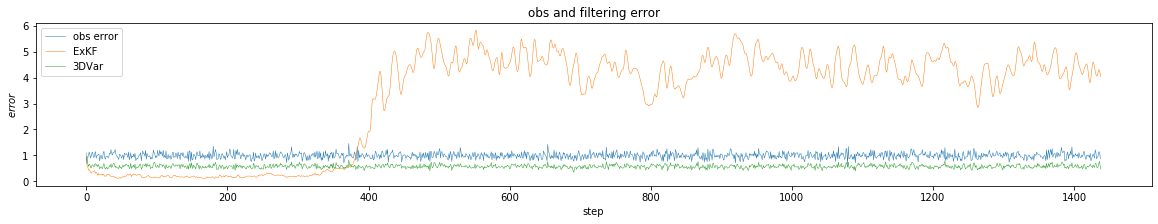

In [217]:
plot_error_KF(true, y, [exkf.x, var3d.x], legends=['ExKF', '3DVar'])

観察
- 破綻するまではExKFの方が3DVarよりよく推定できている．

## ExKFの観測分布への依存性を調べる

間引き方
- 空間方向; 観測行列$H$のrankを落とした際の挙動を調べる．
    - 端の観測値から順に間引く． -> 海陸分布
    - 等間隔で間引く. -> gridが荒い
- 時間方向
    - 同化ステップ幅を倍の0.1(12h)にする．

#### 端の観測値から順に間引く

In [49]:
H_dege = I.copy()
obs_dege_results = []
for j in range(5):
    H_dege[j, j] = 0
    H_dege[J-1-j, J-1-j] = 0
    exkf_obs_dege = ExKF(M, H=H_dege, Q, R, y, x_0, P_0, dim_x=J, dt=dt)
    exkf_obs_dege.forward_estimation(verbose=False)
    obs_dege_results.append(exkf_obs_dege.x)

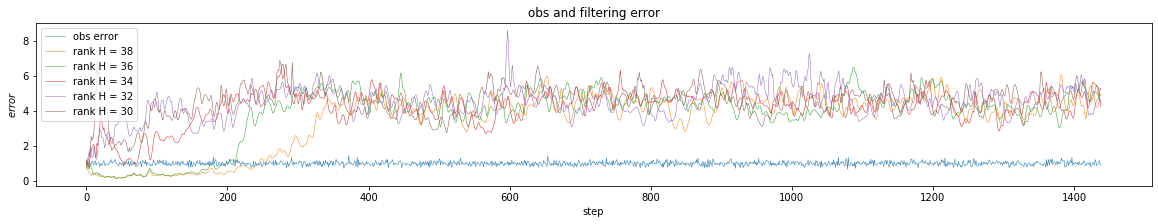

In [166]:
legends = ['rank H = 38', 'rank H = 36', 'rank H = 34', 'rank H = 32', 'rank H = 30']
plot_error_KF(true, y, obs_dege_results, legends)

In [132]:
def plot_error_with_params(true, results, params, param_name):
    """引数
        resultsとparamsの長さは等しい
    """
    T = len(true)
    results = np.array(results)
    filtering_errors = []
    for k in range(len(params)):
        filtering_error = np.array([np.linalg.norm(results[k, t] - true[t])/np.sqrt(J) for t in range(len(true))]).mean()
        filtering_errors.append(filtering_error)
    fig, ax = plt.subplots()
    ax.plot(params, filtering_errors)
    ax.set_xlabel(param_name)
    ax.set_ylabel('rmse time mean')
    plt.xscale('log')
    plt.title('rmse time mean by {}'.format(param_name))

### 3次元変分法のパラメータ依存性

1. $R = rI$として$r$を変化させる．
2. $P_0 = p_0 I$として$p_0$を変化させる．

#### 仮説
- $r$を大きくするとモデルに近づく. 
- $p_0$を大きくするとデータに近づく．


#### 観測誤差$R$を変化させる
- $r$の値を指数的に増加させる．

In [196]:
results_r = []
params_r = []
for k in range(7):
    r = 10**(k-2)
    params_r.append(r)
    R_r = r*I
    var3d_r = ExKF(M, H, Q, R_r, y, x_0, P_0, dim_x=J, dt=dt, var3d=True)
    var3d_r.forward_estimation(verbose=False)
    results_r.append(var3d_r.x)

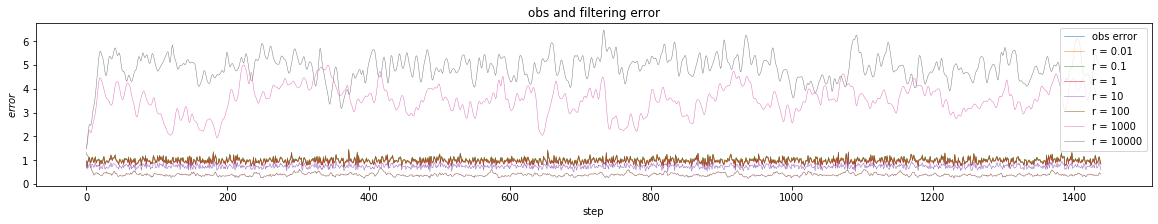

In [197]:
legends_r = ['r = {}'.format(r) for r in params_r]
plot_error_KF(true, y, results_r, legends = legends_r)

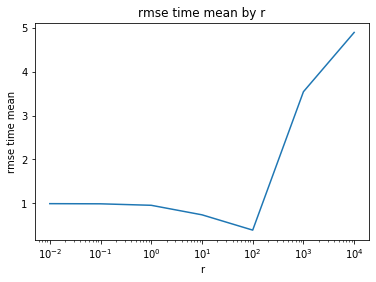

In [198]:
plot_error_with_params(true, results_r, params_r, 'r')

観察
- $r$が小さいと推定が観測データに近づく． 観測誤差~ 推定誤差．
- $r$を大きくすると推定誤差が小さくなるがある値を超えると観測誤差を超えて大きくなる．

#### 誤差共分散$P_0$を変化させる
- $p_0$の値を指数的に増加させる．

In [206]:
results_var3d_p = []
params_p = []
for k in range(7):
    p = 10**(k-4)
    params_p.append(p)
    P_00 = p*I
    var3d_r = ExKF(M, H, Q, R, y, x_0, P_0=P_00, dim_x=J, dt=dt, var3d=True)
    var3d_r.forward_estimation(verbose=False)
    results_var3d_p.append(var3d_r.x)

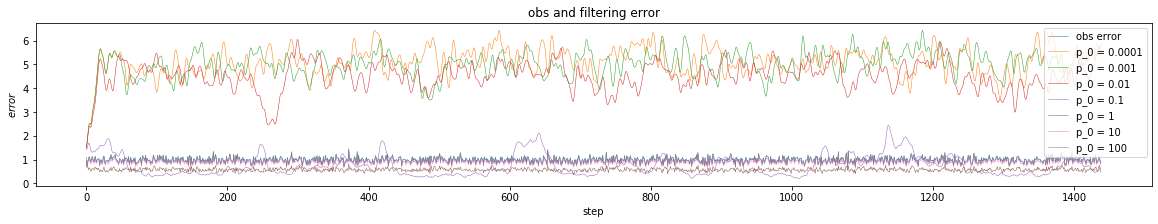

In [207]:
legends_p = ['p_0 = {}'.format(p) for p in params_p]
plot_error_KF(true, y, results_var3d_p, legends = legends_p)

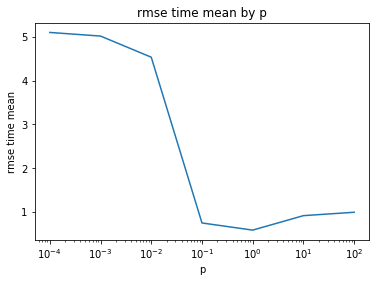

In [208]:
plot_error_with_params(true, results_var3d_p, params_p, 'p')

観察
- $p_0$が小さいと観測誤差を超えて大きい推定誤差になっている．
- $p_0$を大きくすると推定誤差が小さくなるがある値を超えると観測誤差1に近づく．
- $r$を変化させた時と逆の挙動をしている．

### ExKFのパラメータ依存性
1. $R = rI$として$r$を変化させる． ($r=1$で観測データを生成しているので$r=1$が正しい．）
2. $Q = qI$として$q$を変化させる．

仮説
- $r$を大きくするとデータに近づく.
- $q$を大きくするとデータに近づく.


#### 観測誤差$R$を変化させる
- $r$の値を指数的に増加させる．

In [209]:
results_exkf_r = []
params_r = []
for k in range(7):
    r = 10**(k-3)
    params_r.append(r)
    R_r = r*I
    exkf_r = ExKF(M, H, Q, R_r, y, x_0, P_0, dim_x=J, dt=dt)
    exkf_r.forward_estimation(verbose=False)
    results_exkf_r.append(exkf_r.x)

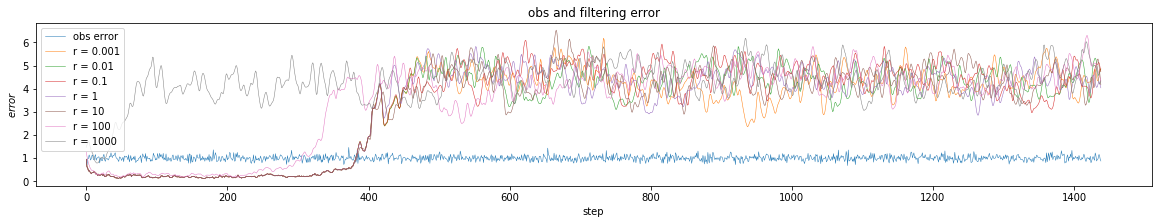

In [210]:
legends_r = ['r = {}'.format(r) for r in params_r]
plot_error_KF(true, y, results_exkf_r, legends = legends_r)

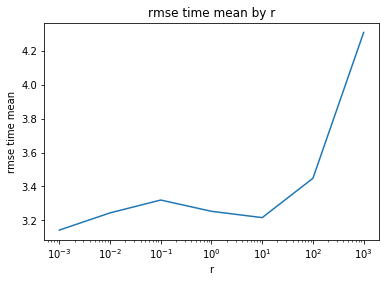

In [211]:
plot_error_with_params(true, results_exkf_r, params_r, 'r')

観察
- $r$を大きくすると途中で破綻しやすくなっている．
  - 原因: 相対的にモデルの信頼度が上がるため．

#### モデル誤差$Q$を変化させる
- $q$の値を指数的に増加させる．

In [212]:
results_exkf_q = []
params_q = []
for k in range(7):
    q = 10**(k-3)
    params_q.append(q)
    Q_q = q*I
    var3d_q = ExKF(M, H, Q_q, R, y, x_0, P_0, dim_x=J, dt=dt)
    var3d_q.forward_estimation(verbose=False)
    results_exkf_q.append(var3d_q.x)

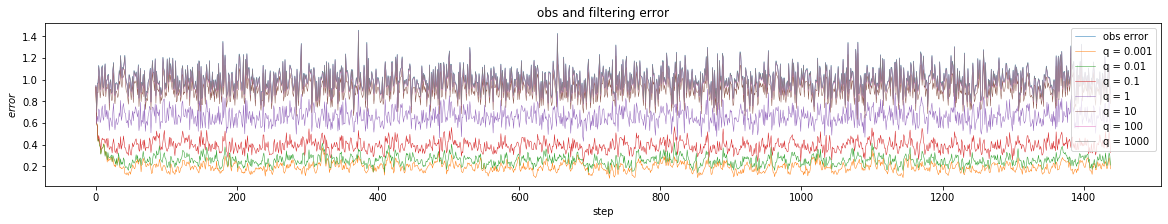

In [213]:
legends_q = ['q = {}'.format(q) for q in params_q]
plot_error_KF(true, y, results_exkf_q, legends=legends_q)

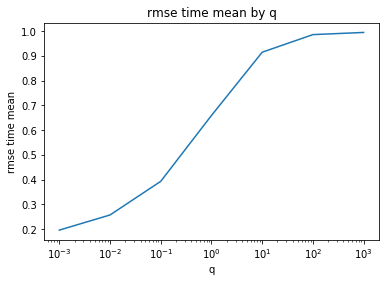

In [214]:
plot_error_with_params(true, results_exkf_q, params_q, 'q')

観察
- 途中で破綻せずに推定を行うことができている．
- $q$を大きくすると推定誤差が観測誤差に近づく．

### 誤差共分散膨張
TODO: 

### 課題まとめ
- モデルの信頼度と観測データの信頼度のバランスで推定が行われている．
- モデルを信用しすぎると観測データのノイズに対応できなくなる.
- 観測データを信用しすぎると観測データと同程度の誤差に落ち着いてしまい推定の意味がない．
- モデルの誤差が0と0.001では大きな違いがある．

### 課題5,6でつまづいたpoint
- 誤差計算: $\sqrt{40}$で割るのを忘れていた．
- KFの実装: モデルが非線形なので予報誤差を計算するときに線形化を行う必要がある．
- KF(ExKF)の結果: 途中で推定が破綻した．
- パラメータ管理: 開発中にコードを行ったり来たりするので変数に想定していない値が入っていることがあり，別の計算を実行していたことがあった．

## 7. EnKFを実装し、KFとの比較実験を行う。
Whitaker and Hamill (2002, MWR)によるEnSRFや、Bishop et al. (2001, MWR)によるETKF、Hunt et al. (Physica D, 2007)によるLETKF等。

TODO: 
- EnKF
- PO
- EnSRF
- LETKF

## 8. 4次元変分法を実装し、比較する。4次元変分法には、アジョイントモデルを構築するほか、近似的に40x40行列の線形モデルを生成する方法もある。
もしアジョイントモデルを構築すれば、近似的な線形モデル行列との違いについて調べてみるのも面白いかもしれない。モデルの非線形性の調査になる。
線形モデルの場合一致することを確認する。


## 9. 発展的課題：完全モデルを仮定してきたが、モデル誤差を導入して同様の調査を行ってみる。

## 10. 自分で考える
TODO: particle filter

## memo

### by 前島 on 2020/09/04
パラメータ
- $P_0 = 25I$は適切.


### by 高玉 on 2020/09/08
課題の道筋
- 4dVarはあまり旨味がないかも

- 気象業界: EnKF
  - 気象庁: LETKF
- 海洋業界: 4dVar

データ同化の応用
- 非線形現象
- 赤潮の予報
- 物を曲げる
- 降水は難しい

## 参考
- Lorenz and Emanuel, 1998: Optimal sites for supplementary weather observations:Simulation with a small model. J. Atmos. Sci., 55, 399−414.
- [Lorenz96モデルのデータ同化:準備編](https://qiita.com/litharge3141/items/41b8dd3104413529407f) - 2020/08/17
- [Lorenz96モデルのデータ同化:Extended Kalman Filter](https://qiita.com/litharge3141/items/7c1c879240d6c9d46166) - 2020/09/03